## The aim of the project is to build a model for forecasting real estate prices in Katowice, the capital of the Silesian Province in Poland.

## Importing libraries

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, root_mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, skew, kurtosis
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

## Reading and cleaning the data regarding housing market in Katowice, Poland

In [149]:
df = pd.read_csv('katowice_data.csv')

In [150]:
df.head()

,Unnamed: 0,price,price_m2,area,rooms,district,heating_type,floor,state_of_completion,market,...,balcony,garage,terrace,garden,basement,seperate_kitchen,monitoring,closed_area,district_heating,advertiser_real_estate_agency
0,0,539000.0,8167,66.00,4,śródmieście,district_heating,2,for_residential_use,resale_market,...,1,0,0,0,1,1,0,0,1,0
1,1,445000.0,10595,42.00,2,śródmieście,district_heating,1,for_finishing,primary_market,...,1,1,0,0,0,0,0,0,1,0
2,4,516000.0,8990,57.40,3,śródmieście,district_heating,0,for_residential_use,resale_market,...,1,0,0,0,1,0,0,0,1,0
3,5,480000.0,9231,52.00,3,bogucice,district_heating,0,for_residential_use,resale_market,...,1,0,0,0,1,0,0,0,1,1
4,6,455000.0,11475,39.65,2,wełnowiec-józefowiec,district_heating,1,for_finishing,resale_market,...,1,1,0,0,0,0,0,1,1,1


In [151]:
df = df.iloc[:,1:]
df = df.loc[(df['price']>=300000) & (df['price']<=1000000)]

In [152]:
len(df)

1415

### Counting offers from different districts in Katowice

In [153]:
df_district = df.district.value_counts().reset_index()

In [154]:
df_district['share'] = df_district['count']/np.sum(df_district.iloc[:,1])

In [155]:
df_district.sort_values('share',ascending=False)

,district,count,share
0,śródmieście,271,0.191519
1,wełnowiec-józefowiec,223,0.157597
2,ligota-panewniki,115,0.081272
3,brynów-osiedle zgrzebnioka,100,0.070671
4,bogucice,97,0.068551
5,osiedle paderewskiego-muchowiec,96,0.067845
6,osiedle tysiąclecia,84,0.059364
7,koszutka,79,0.055830
8,dąb,69,0.048763
9,kostuchna,58,0.040989


### Categorical variables' frequencies

In [156]:
for col in df.select_dtypes(object).columns.to_list():
    print(f'Variable: {col}\n\n{df[col].value_counts()}\n\n')

Variable: district

district
śródmieście                        271
wełnowiec-józefowiec               223
ligota-panewniki                   115
brynów-osiedle zgrzebnioka         100
bogucice                            97
osiedle paderewskiego-muchowiec     96
osiedle tysiąclecia                 84
koszutka                            79
dąb                                 69
kostuchna                           58
załęska hałda-brynów                57
piotrowice-ochojec                  56
janów-nikiszowiec                   34
osiedle witosa                      24
zawodzie                            22
załęże                              18
szopienice-burowiec                 12
Name: count, dtype: int64


Variable: heating_type

heating_type
district_heating    1222
gas_heating          116
other                 42
boiler_room           19
electric_heating      16
Name: count, dtype: int64


Variable: state_of_completion

state_of_completion
for_residential_use    797
for_finishin

## Exploratory analysis

### Median prices per m^2 by market type

In [157]:
df.groupby('market')['price_m2'].median()

market
primary_market    11265.0
resale_market      9260.0
Name: price_m2, dtype: float64

#### Median prices at the primary market are ~21% higher than at the resale market

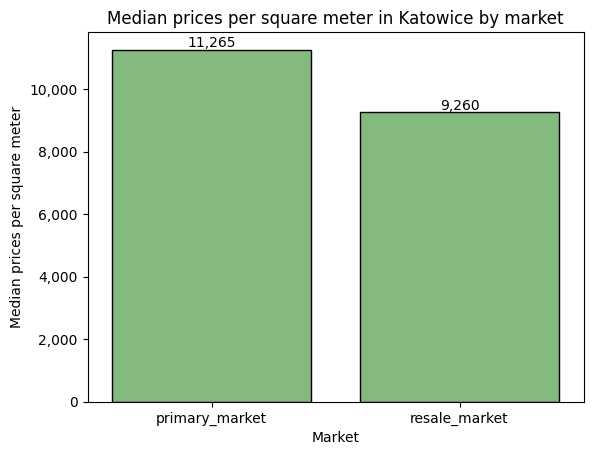

In [160]:
bar = sns.barplot(data=df.groupby('market')['price_m2'].median().reset_index(),
            x='market',
            y='price_m2',
            color="#7cc473",
            edgecolor='black')

for container in bar.containers:
    bar.bar_label(container, fmt='{:,.0f}')
    
plt.xlabel('Market')
plt.ylabel('Median prices per square meter')
plt.title('Median prices per square meter in Katowice by market')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

### Median prices and housing area by district

### 
1. Median housing price amounts to 516000 PLN
2. Median price per m^2 amounts to 10386 PLN
3. Median area amounts to 52.3 m
3. Bogucice remains the most expensive district in terms of median price per m^2 and Załęże -  the least expensive
4. Bogucice also has the lowest housing area - and Kostuchna the highest, which is likely the reason why Kostuchna has the highest property prices overall

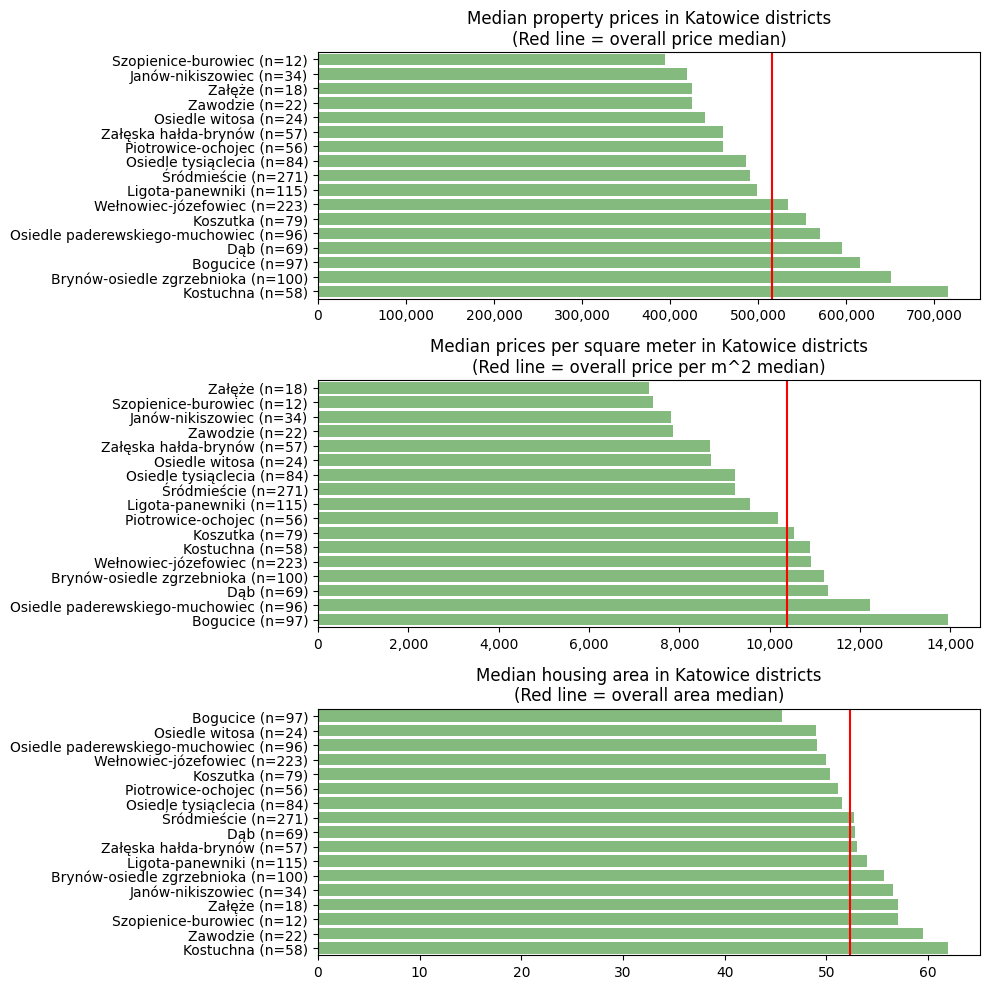

In [161]:
fig, axes = plt.subplots(ncols=1,nrows=3,figsize=(10,10))
axes = axes.flatten()

liczebnosc_dzielnic = df.district.value_counts()

for ind, col in  enumerate(['price','price_m2','area']):

    data=df.groupby('district')[col].median().sort_values(ascending=True).reset_index()
    data['n'] = data['district'].map(liczebnosc_dzielnic)
    data['district'] = data['district'] + ' (n=' + data['n'].astype(str) + ')'
    data['district'] = data['district'].apply(lambda x: x.capitalize())

    sns.barplot(data=data,
            x=col,
            y='district',
            color="#7cc473",
            ax=axes[ind])
    axes[ind].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    
    if ind == 0:
        axes[ind].set_title('Median property prices in Katowice districts\n(Red line = overall price median)')
        axes[ind].axvline(x=df["price"].median(),color='red')

    elif ind == 1:
        axes[ind].set_title('Median prices per square meter in Katowice districts\n(Red line = overall price per m^2 median)')
        axes[ind].axvline(x=df["price_m2"].median(),color='red')

    else:
        axes[ind].set_title('Median housing area in Katowice districts\n(Red line = overall area median)')
        axes[ind].axvline(x=df["area"].median(),color='red')

    axes[ind].set_xlabel('')
    axes[ind].set_ylabel('')
    
plt.tight_layout()
plt.show()

#### Introducing 2 new variables:
- district_heating (binary)
- advertiser_real_estate_agency (binary)

These variables are based on heating_type and advertiser variables - which have a lot of categories, but introducing them as separate dummy variables leads to multicollinarity because a lot of these categories are rare and therefore it makes more sense to exclude these variables from the model and replace them with district_heating (1/0) and advertiser_real_estate_agency (1/0)

### Price distribution

#### The target variable is not normally distributed but there are no residuals

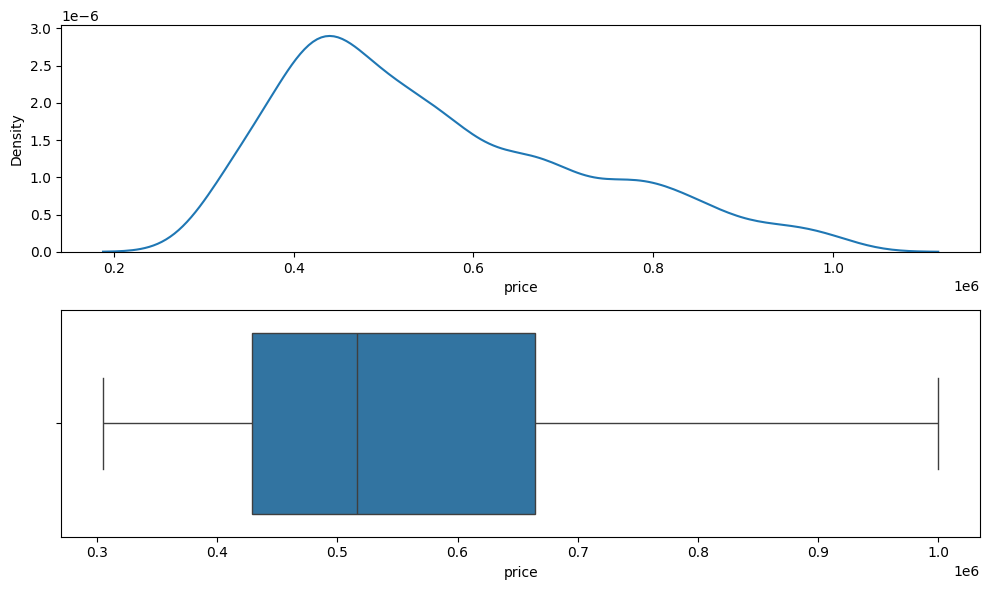

In [166]:
fig, axes = plt.subplots(ncols=1,nrows=2,figsize=(10,6))

axes = axes.flatten()

sns.kdeplot(data=df['price'],
            ax=axes[0])

sns.boxplot(data=df,
            x='price',
            ax=axes[1])
   
#axes[ind].set_title(title)
    
plt.tight_layout()
plt.show()

## Modeling part

### Data partition

In [168]:
X = df.drop(["price","floors_total","price_m2","advertiser_type",'heating_type','rooms'],axis=1)
y = df["price"]

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.65,random_state=465)

X_train = pd.get_dummies(data=X_train,columns = ['market','type_of_development',
                                                'district','state_of_completion'],
                                                drop_first=True,
                                                dtype='int32')

X_test = pd.get_dummies(data=X_test,columns = ['market','type_of_development',
                                                'district','state_of_completion'],
                                                drop_first=True,
                                                dtype='int32')

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (919, 34)
X_test: (496, 34)
y_train: (919,)
y_test: (496,)


In [169]:
X_train.head()

,area,floor,elevator,balcony,garage,terrace,garden,basement,seperate_kitchen,monitoring,...,district_osiedle witosa,district_piotrowice-ochojec,district_szopienice-burowiec,district_wełnowiec-józefowiec,district_zawodzie,district_załęska hałda-brynów,district_załęże,district_śródmieście,state_of_completion_for_renovation,state_of_completion_for_residential_use
1130,50.00,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
677,72.00,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
906,40.50,1,1,1,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
627,37.30,0,1,0,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
765,53.03,7,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Variance inflation rate (VIF)

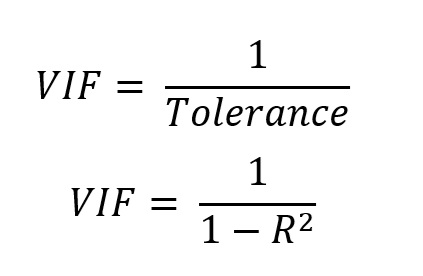

In [170]:
display(Image(filename='VIF-Formula.jpg'))

#### The VIF indicator involves regressing each independent variable against all other independent variables, expecting a low R^2 result (if R^2 is high it may introduce collinearity to the model). The VIF indicator should not exceed a value of ~10.0.

In [171]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]

print(vif_data)

                                     feature        VIF
0                                       area  11.300250
1                                      floor   3.246201
2                                   elevator   5.858135
3                                    balcony   4.468728
4                                     garage   3.424315
5                                    terrace   1.618512
6                                     garden   1.488895
7                                   basement   2.788176
8                           seperate_kitchen   2.047446
9                                 monitoring   2.590702
10                               closed_area   2.205519
11                          district_heating   9.879546
12             advertiser_real_estate_agency   3.723140
13                      market_resale_market   9.664428
14    type_of_development_apartment_building   3.606028
15        type_of_development_tenement_house   2.035931
16       district_brynów-osiedle zgrzebnioka   1

### Measuruments of error

### Random forest model

In [172]:
rf_mod = RandomForestRegressor(n_estimators=100,random_state=123)

In [173]:
rf_mod.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

- On average, random forest predictions are off by about 43488 PLN
- On average, random forest predictions are 7.97% off from the actual values


In [174]:
print(f"Random Forest MAE: {round(mean_absolute_error(y_true = y_test, y_pred = rf_mod.predict(X_test)),4)}")
print(f"Random Forest MAPE: {round(mean_absolute_percentage_error(y_true = y_test, y_pred = rf_mod.predict(X_test)),4)}")
print(f"Random Forest RMSE: {round(root_mean_squared_error(y_true = y_test, y_pred = rf_mod.predict(X_test)),4)}")

Random Forest MAE: 43488.2663
Random Forest MAPE: 0.0797
Random Forest RMSE: 66797.1565


In [175]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2]
    #'max_depth': [3,4,5,6]
}

In [176]:
xg_reg = XGBRegressor()

In [177]:
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

In [178]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [179]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [180]:
best_params

{'learning_rate': 0.1, 'n_estimators': 200}

In [181]:
xg_reg = XGBRegressor(**best_params)

In [182]:
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

- On average, XGBoost predictions are off by about 42796 PLN
- On average, XGBoost forest predictions are 7.89% off from the actual values

In [183]:
print(f'XGBOOST MAE: {mean_absolute_error(y_true = y_test, y_pred = xg_reg.predict(X_test))}')
print(f'XGBOOST MAPE: {mean_absolute_percentage_error(y_true = y_test, y_pred = xg_reg.predict(X_test))}')
print(f'XGBOOST RMSE: {root_mean_squared_error(y_true = y_test, y_pred = xg_reg.predict(X_test))}')

XGBOOST MAE: 42796.30846774193
XGBOOST MAPE: 0.07881499763040078
XGBOOST RMSE: 65013.992877883284


### Comparing predicted values to actual values

#### The model makes nominally larger errors for properties that are more expensive (above approx. PLN 600,000).

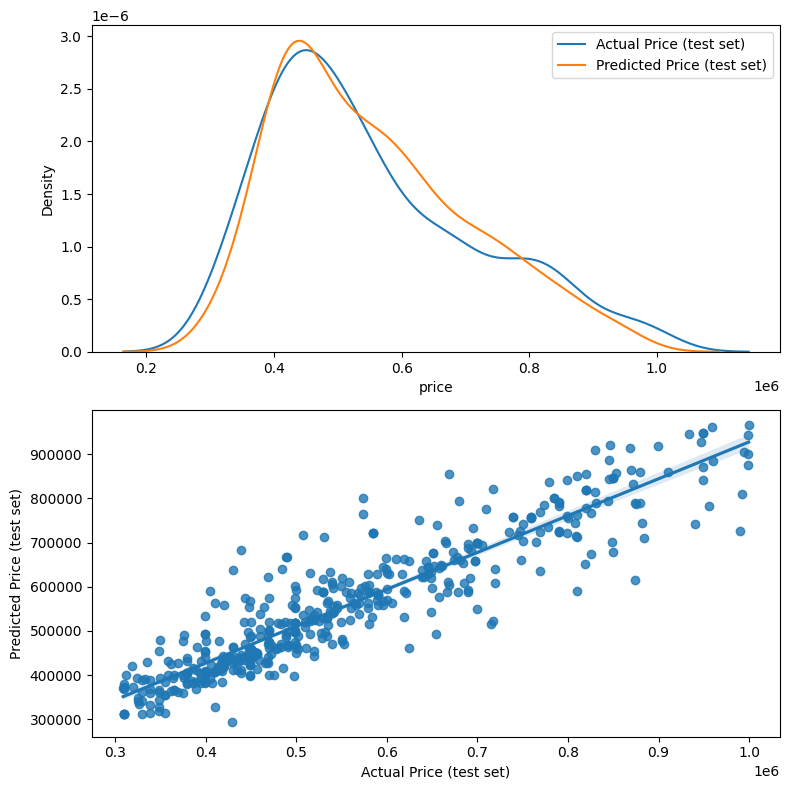

In [141]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(8,8))


sns.kdeplot(data=y_test,label="Actual Price (test set)",ax=axes[0])
sns.kdeplot(data=xg_reg.predict(X_test),label="Predicted Price (test set)",ax=axes[0])
axes[0].legend()


res = y_test - xg_reg.predict(X_test)

sns.regplot(x=y_test, y = xg_reg.predict(X_test),ax=axes[1])
axes[1].set_xlabel("Actual Price (test set)")
axes[1].set_ylabel("Predicted Price (test set)")

plt.tight_layout()
plt.show()

In [142]:
df_error = pd.DataFrame({"residual":res,"actual_value":y_test,"xgboost_prediction":xg_reg.predict(X_test)})

In [143]:
def value_bucket(x):
    if x < 300000:
        return '<300 000'
    elif x >= 300000 and x < 400000:
        return '[300 000;400 000)'
    elif x >= 400000 and x < 500000:
        return '[400 000;500 000)'
    elif x >= 500000 and x < 600000:
        return '[500 000;600 000)'
    elif x >= 600000 and x < 700000:
        return '[600 000;700 000)'
    elif x >= 700000 and x < 800000:
        return '[700 000;800 000)'
    elif x >= 800000 and x < 900000:
        return '[800 000;900 000)'
    elif x >= 900000 and x < 1000000:
        return '[900 000;1 000 000)'
    else:
        return '>=1 000 000'

In [144]:
df_error['bucket']  = df_error['actual_value'].apply(value_bucket)
df_error['absolute_residual'] = np.abs(df_error['residual'])
df_error['res_div_by_act_val'] = df_error['absolute_residual']/df_error['actual_value']

#### MAPE is higher for real estates priced between [300000;400000), [800000;900000) and [900000;1000000) - the reason could be that real estates with such prices are underrepresented in the data set

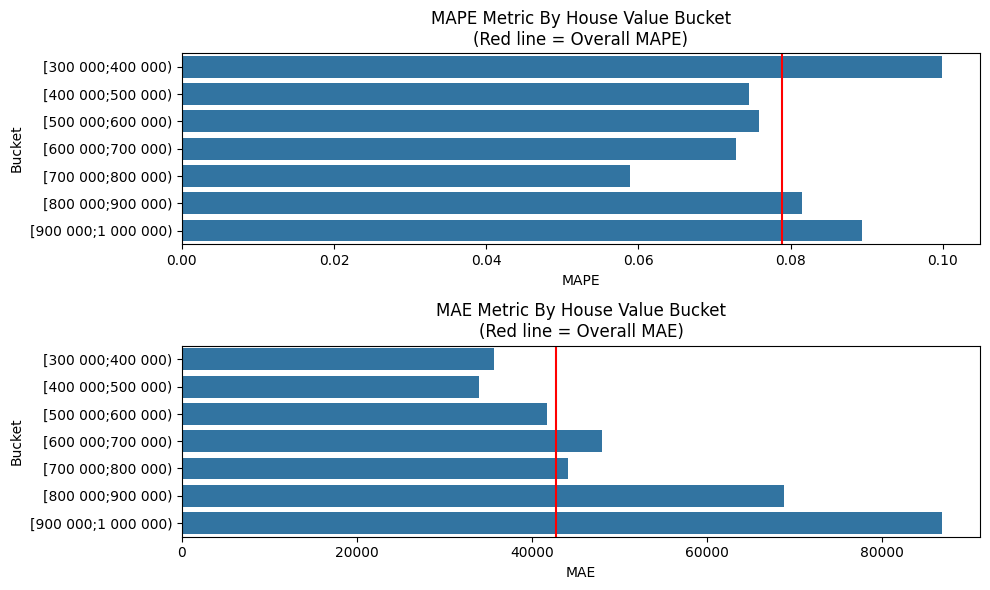

In [145]:
fig, axes = plt.subplots(ncols = 1,nrows=2,figsize=(10,6))


sns.barplot(data=df_error.groupby('bucket')['res_div_by_act_val'].mean().reset_index(name='MAPE'),
            y='bucket',x='MAPE',order = ['[300 000;400 000)',
                                         '[400 000;500 000)','[500 000;600 000)','[600 000;700 000)',
                                         '[700 000;800 000)','[800 000;900 000)','[900 000;1 000 000)'],
                                         ax = axes[0])
axes[0].axvline(x=mean_absolute_percentage_error(y_true = y_test, y_pred = xg_reg.predict(X_test)),color='red')
axes[0].set_title('MAPE Metric By House Value Bucket\n(Red line = Overall MAPE)')
axes[0].set_ylabel("Bucket")



sns.barplot(data=df_error.groupby('bucket')['absolute_residual'].mean().reset_index(name='MAE'),
            y='bucket',x='MAE',order = ['[300 000;400 000)',
                                         '[400 000;500 000)','[500 000;600 000)','[600 000;700 000)',
                                         '[700 000;800 000)','[800 000;900 000)','[900 000;1 000 000)'],
                                         ax = axes[1])
axes[1].axvline(x=mean_absolute_error(y_true = y_test, y_pred = xg_reg.predict(X_test)),color='red')
axes[1].set_title('MAE Metric By House Value Bucket\n(Red line = Overall MAE)')
axes[1].set_ylabel("Bucket")

plt.tight_layout()
plt.show()

### Using SHAP values to determine variables' importance

#### XGboost model chose area as the most influential variable. Variables such as whether or not the real estate is an apartment, whether it's for residential use, whether there is an elevator, whether the offer comes from the resale market, whether there is a seperate kitchen, the floor seem to be more important than the rest of the variables

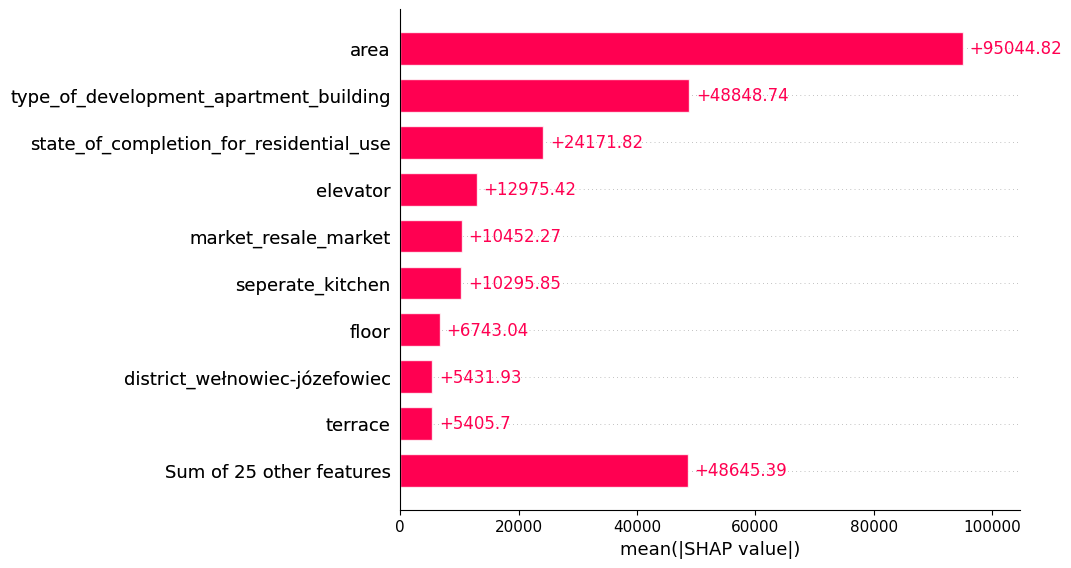

In [146]:
df_error['absolute_residual'] = np.abs(df_error['residual'])


df_error['res_div_by_act_val'] = df_error['absolute_residual']/df_error['actual_value']


explainer = shap.TreeExplainer(xg_reg)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)


explainer = shap.TreeExplainer(xg_reg)

# Call explainer -> returns Explanation object
shap_values = explainer(X_test)

# Beeswarm plot (global feature importance)
shap.plots.bar(shap_values)